In [1]:
import os
import ast
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture
from dotenv import load_dotenv, find_dotenv
from typing import Optional

# ¿Cómo funciona O-Llama y Groq?

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings(
)

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)

# Eliminar la primera página o portada del doc.

In [3]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')

docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

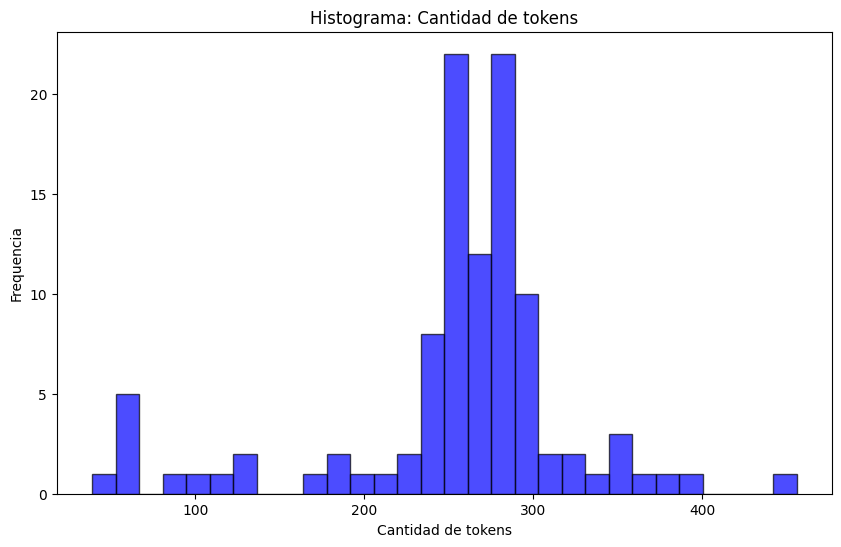

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.show()

In [5]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 26815


# 1. ¿Incrustar de cero?
# 2. ¿Elegir un encrustamiento guardado?

In [6]:
user_input = input("Elige 1 o 2: ")

if user_input.lower() == "1":
    print('Elegiste 1')
    global_embeddings = [embeddings.embed_query(txt) for txt in texts]

    embed_name = input('¿Cómo se llama esta incrustación?: ') + '_emb' + '.txt'
    with open(rf'./embed/{embed_name}', 'w') as f:
        for i in global_embeddings:
            f.write("%s\n" % i)
    
elif user_input.lower() == "2":
    print('Elegiste 2')
    global_embeddings = []

    embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

    with open(rf'./embed/{embed_name}', 'r') as f:
        for i in f:
            x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de números
            global_embeddings.append(x)

    global_embeddings = np.array(global_embeddings, dtype=float)
    
elif user_input != "1" and user_input != "2":
    print("No seleccionaste ningún encrustamiento.")

Elegiste 1


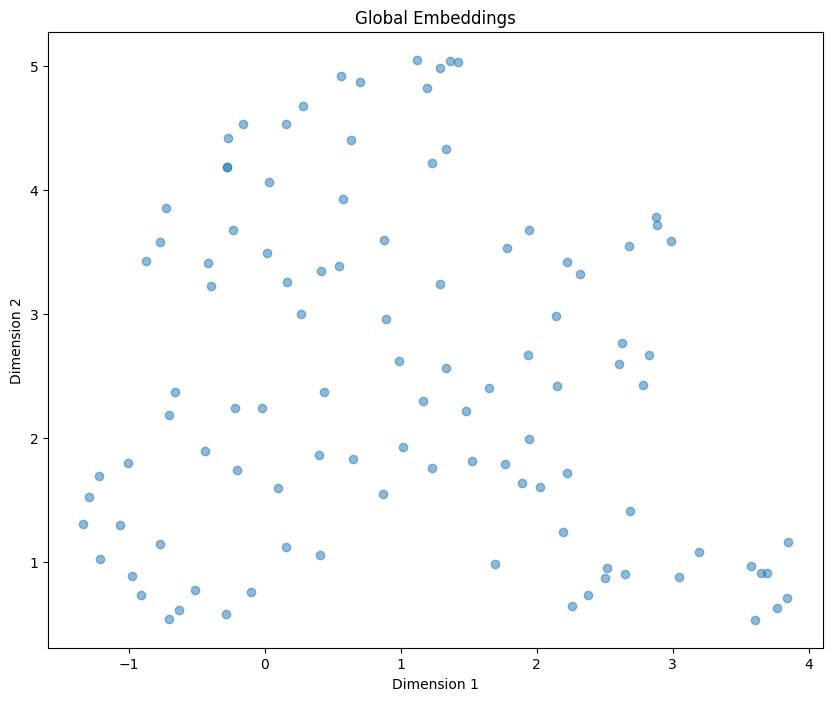

In [7]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


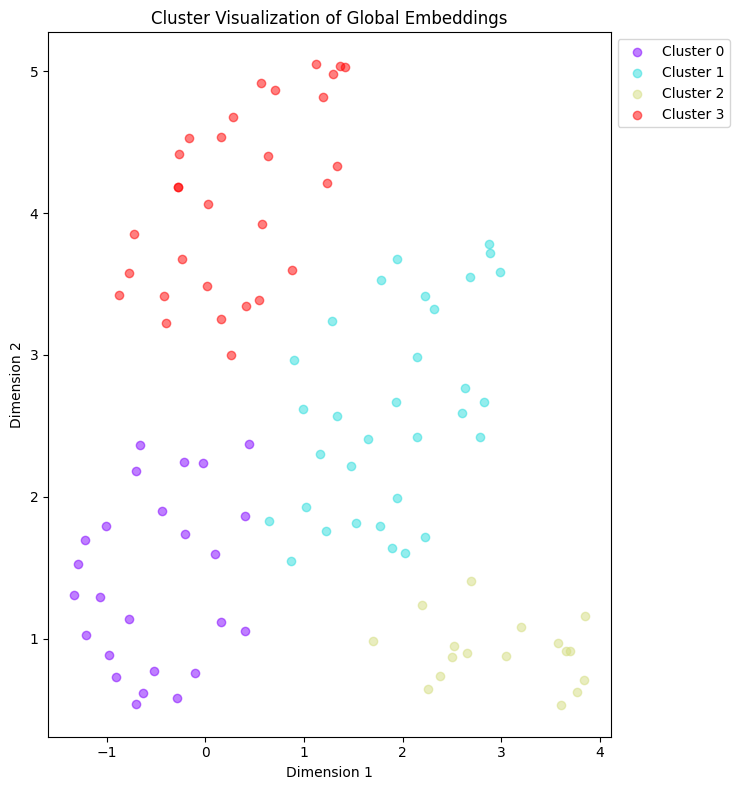

In [8]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.75, 1])

In [9]:
simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
# print(df.head(3))
df.head()

,Texto,Embedding,Cluster
0,© Unilibre Cali52 Entramado ...,"[1.5244449, 1.8178705]",1
1,"“Marketing Territorial, una alternativa para l...","[2.6883864, 1.4088124]",2
2,de las ventajas comparativas que el territorio...,"[2.3767037, 0.73816174]",2
3,la competitividad y el posicionamiento regiona...,"[2.0234745, 1.6032451]",1
4,"of La Union, Zarzal and Cartago during the per...","[2.221877, 1.716011]",1


In [10]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{1: '© Unilibre Cali52 Entramado                    Vol. 11 No. 2, 2015 (Julio - Diciembre) El territorio y su relación con las ventajas comparativas   y competitivas en el municipio de La Unión, Valle del  Cauca, Colombia * Magdalida Murgueitio Magíster en Educación y Desarrollo Humano, Universidad de San Buenaventura, Cali - Colombia. Docente de tiempo completo de la Facultad de  Ciencias Económicas de la Universidad de San Buenaventura. Cali, Colombia  mmurguei@usbcali.edu.co, magdalida@gmail.com Verena González-Cabo Doctoranda en Administración, Universidad del Valle, Cali - Colombia. Magíster en Administración.de Empresas,  Universidad del Valle, Cali - Colombia. Profesora Asociada a la Facultad de Ciencias Económicas de la Universidad de San Buenaventura. Cali, Colombia vgonzale@usbcali.edu.co, verenagon@gmail.com  Re s u m e n En el marco del proyecto de investigación denominado “Marketing Territorial, una alternativa para la competitividad y posicionamiento regional en los --- 

In [11]:
template = """Eres un revisor bibliográfico profesional encargado de crear resúmenes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [12]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

embedded_summaries = [embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [13]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

clustered_summaries

{0: ['clave para su competitividad. En: Actual Problems of Economics, [en línea] (9), 98-105, 2012. Disponible en Internet: <www.scopus.com> 19. MURGUEITIO, Magdalida y GONZÁLEZ-CABO, Verena. El territorio y su relación con las ventajas comparativas y competitivas en el municipio de La Unión, Valle del Cauca, Colombia. En: Entramado. Julio - Diciembre 2015 vol. 11, no. 2, p. 52-70, http://dx.doi.org/10.18041/entramado.2015v11n2.22201 20. POPKOVA, E. G.; DUBOVA, J. I.; and ROMANOVA, M. K. The territorial marketing strategy as a factor of regional competitiveness. En: World Applied Sciences Journal, [en línea] 22: 123-129, 2013. Disponible en Internet: <www.idosi.org> 21. PROGRAMA DE DESARROLLO DEL MUNICIPIO DE LA UNIÓN. Plan de Desarrollo 2012-2015. [en línea] 2012. Disponible en Internet: <http://www.launion-valle.gov.co/apc-aa-files/66383231663939633664633034616239/plan-de-desarrollo-2012-2015.pdf> 22. RIVERA, Eugenio. Programa De Gobierno ¡La Unión En Buenas Manos! Alcalde 2012-2015.

In [14]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{0: 'El artículo proporcionado aborda la relación entre el territorio y las ventajas comparativas y competitivas en el municipio de La Unión, Valle del Cauca, Colombia, desde un enfoque de marketing territorial. Las autoras, Magdalida Murgueitio y Verena González-Cabo, analizan cómo el territorio influye en la competitividad y el posicionamiento regional, destacando la importancia de la vocación agrícola y pecuaria, la educación, la infraestructura, la asociatividad empresarial y el turismo.\n\nEl estudio se basa en investigaciones previas sobre estrategias de desarrollo regional y marketing territorial, centrándose en el municipio de La Unión en el contexto de la región norte del Valle del Cauca. Se identifican desafíos y oportunidades para mejorar la competitividad y el desarrollo económico local, como fortalecer la educación, promover la asociatividad empresarial y mejorar la infraestructura y la conectividad vial.\n\nSe destaca la importancia de considerar el territorio como un fac

In [15]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [ ]:
combined_texts[:10]

In [16]:
# Nombre del archivo de texto
file_name = input('Nombre del archivo: ') + '.txt'

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [17]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./kbs/{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [18]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

41


In [19]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas que involucren peticiones. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [20]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [30]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es el nombre del artículo?
El nombre del artículo es "El territorio y su relación con las
ventajas comparativas y competitivas en el municipio de La Unión,
Valle del Cauca, Colombia".

Referencias:
page_content='[citado en agosto 28 de 2014]  Disponible en Internet:  <http://www.idosi.org/wasj/wasj18%28Eco - nomics%2912/30.pdf> 3. BERICAT, Eduardo. La integración de los métodos cuantitativo y cua-litativo en la investigación social. Significado y medida. Barcelona: Ariel, 1998. 4. BOISIER, Sergio (2006). La imperiosa necesidad de ser diferente en la globalización: el mercadeo territorial. La experiencia de las regiones  chilenas. En: T erritorios, Núm. 15, agosto-diciembre, 2006, pp. 71-85.  [en línea] Universidad del Rosario. [citado en junio 2 de 2014] Dispo- nible en Internet: <http://redalyc.uaemex.mx/pdf/357/35711624005.pdf> 5. BOLETÍN SOCIOECONÓMICO DE LA SUBREGIÓN NORTE No.  1. Participación laboral. [en línea] julio de 2013. [citado en junio 25  de 2014] Disponible en Int

In [23]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Quiénes son los autores del artículo y a qué universidad pertenecen?
Los autores del artículo son Magdalida Murgueitio y Verena González-
Cabo. Pertenecen a la Universidad de San Buenaventura, en Cali,
Colombia.

Referencias:
page_content='que permitan establecer un con-cepto propio de región. Los textos revisados corresponden a bibliografía actualizada, producto de investigaciones en estas áreas del conocimiento, como también a los docu-mentos institucionales de los municipios.  Segunda fase Se aplican entrevistas semiestructuradas según el perfil de las instituciones y del funcionario que suministra la informa-ción (secretario de Gobierno, secretario de Prensa, Alcalde, director de la oficina de la Umata y otros funcionarios dis-ponibles en los días en que se hace el trabajo de campo). También se realizan entrevistas con familias, empresarios, trabajadoras de la uva, líderes sociales, algunas personas de la región. Así mismo, se efectúa una observación directa no participante de las

In [25]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿En qué fecha fue publicado el artículo?
El artículo fue publicado en junio de 2013.

Referencias:
page_content='Entramado                    Vol. 11 No. 2, 2015 (Julio - Diciembre) © Unilibre Cali70 6. BOLETÍN SOCIOECONÓMICO DE LA SUBREGIÓN NORTE No.  2. Retorno a la educación y segmentación del mercado laboral. [en línea] julio de 2013. [citado en junio 25 de 2014] Disponible en In-ternet: <http://www.valledelcauca.gov.co/planeacion/publicaciones.php?id=24721> 7. BOLETÍN SOCIOECONÓMICO DE LA SUBREGIÓN NORTE No. 3. [en línea] julio de 2013. Caracterización socioeconómica. [citado  en junio 25 de 2014] Disponible en Internet: http://www.valledelcau- ca.gov.co/planeacion/publicaciones.php?id=24721 8. CBONLINECALI. El Parque Nacional de la Uva. [en línea]. Disponible en Internet: <http://www.cbonlinecali.com/el-parque-nacional-de-la-uva/> 9. CONSEJO PRIVADO DE COMPETITIVIDAD. Informe Nacional de Competitividad 2012-2013. [en línea] 2012.  Disponible en Internet:  <http://www.compite.com.

In [21]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Puedes hacer una síntesis detallada del artículo?
Para hacer una síntesis detallada del artículo, es importante destacar
que se aborda la relación entre el territorio y las ventajas
comparativas y competitivas en el municipio de La Unión, Valle del
Cauca, desde un enfoque de marketing territorial. Se analiza cómo el
territorio influye en la competitividad y el posicionamiento regional,
resaltando la importancia de la vocación agrícola y pecuaria, la
educación, la infraestructura, la asociatividad empresarial y el
turismo. Se mencionan las iniciativas locales para mejorar la calidad
de vida de los habitantes, así como los desafíos en materia educativa,
laboral y de infraestructura. Se plantean propuestas para potenciar
las ventajas competitivas y comparativas del municipio, con el
objetivo de impulsar su desarrollo económico y social.

Referencias:
page_content='que permitan establecer un con-cepto propio de región. Los textos revisados corresponden a bibliografía actualizada, producto

In [26]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles son los objetivos del artículo?
Los objetivos del artículo son identificar las alternativas
potenciales para la competitividad y el posicionamiento regional en el
municipio de La Unión, Valle del Cauca, desde un enfoque de marketing
territorial. Se busca analizar cómo el territorio influye en la
competitividad y el posicionamiento regional, destacando la
importancia de la vocación agrícola y pecuaria, la educación, la
infraestructura, la asociatividad empresarial y el turismo. Además, se
pretende desglosar las ventajas competitivas y comparativas del
municipio, así como proponer recomendaciones para potenciarlas y
mejorar el desarrollo económico local.

Referencias:
page_content='variables que se definieron para este estudio que pretende como objetivo general, identificar las alterna-tivas potenciales para la competitividad y el posicionamien-to regional del norte del Valle del Cauca.  Para lograrlo, primero se examinan las ventajas competi- tivas/comparativas de la región y se

In [27]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es la metodología usada en el estudio?
La metodología empleada en el estudio se basa en la triangulación de
técnicas e información, incluyendo la documentación oficial del
municipio, entrevistas semiestructuradas con diferentes actores como
el alcalde, la dirección de la Unidad Municipal de Asistencia Técnica
Agropecuaria, secretarios, líderes sociales, empresarios, gerentes y
trabajadores, y observación directa en la dinámica diaria de los
habitantes del municipio, complementada con un registro fotográfico.
La investigación se desarrolla de manera exploratoria y descriptiva,
con un diseño por fases, buscando identificar las alternativas
potenciales para la competitividad y el posicionamiento regional del
norte del Valle del Cauca. Además, se integran métodos cualitativos y
cuantitativos, abordando dimensiones como el marketing territorial,
desarrollo local y regional, competitividad y conectividad, y se
emplea la observación no participante y la entrevista semiestructurada
como 

In [28]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles fueron los resultados?
Los resultados obtenidos en el estudio se basaron en la identificación
de desafíos y oportunidades para mejorar la competitividad y el
desarrollo económico local en el municipio de La Unión, en el contexto
de la región norte del Valle del Cauca. Se destacó la importancia de
considerar el territorio como un factor clave en la competitividad y
el desarrollo regional, proponiendo recomendaciones para potenciar las
ventajas comparativas y competitivas del municipio. Además, se
mencionó la necesidad de contar con el apoyo de las autoridades
locales y la comunidad para lograr resultados exitosos.

Es importante resaltar que los resultados del estudio reflejaron la
necesidad de fortalecer la educación, promover la asociatividad
empresarial y mejorar la infraestructura y la conectividad vial en el
municipio. Además, se evidenció la importancia de desarrollar
estrategias de marketing territorial para potenciar las ventajas
competitivas del territorio. En resumen, 

In [29]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Qué es lo más destacable en términos de investigación de este estudio?
Lo más destacable en términos de investigación de este estudio es la
aplicación de la triangulación metodológica, que permite obtener datos
con diferentes técnicas e instrumentos, como la observación no
participante, las entrevistas semiestructuradas a funcionarios
públicos y la recopilación de datos estadísticos de los municipios en
diferentes rubros. Además, el análisis realizado por un equipo de
investigadores de diversas disciplinas como Economía, Contaduría,
Administración, Ingeniería de Sistemas y Educación, aporta una visión
multidisciplinaria que enriquece la investigación. Esta combinación de
métodos y enfoques permite obtener resultados más completos y
detallados, que son fundamentales para comprender y mejorar la
competitividad y el desarrollo regional en los municipios estudiados.

Referencias:
page_content='fotográfico de la región. Tercera fase Selección, categorización, análisis e interpretación de l

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

# Hacer historial y guardar conversaciones para medir efectividad.

In [ ]:
# Para archivos grandes debes dividir el texto

# # Diccionario inicial
# data = {
#     2: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN. El propósito de la investigación es analizar'
# }

# # Obtener el texto original
# original_text = data[2]

# # Encontrar el punto medio
# mid_point = len(original_text) // 2

# # Definir el tamaño del solapamiento
# overlap_size = 50

# # Calcular los puntos de división con solapamiento
# start_overlap = max(mid_point - overlap_size // 2, 0)
# end_overlap = min(mid_point + overlap_size // 2, len(original_text))

# # Dividir el texto en dos partes con solapamiento
# first_half = original_text[:end_overlap]
# second_half = original_text[start_overlap:]

# # Crear nuevas llaves en el diccionario
# data[2] = first_half
# data[3] = second_half

# # Imprimir el diccionario actualizado
# print(data)